In [12]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [13]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [14]:
pl.seed_everything(101)

Global seed set to 101


101

In [15]:
df = pd.read_csv('news_summary/news_summary.csv', encoding='latin-1')
df = df[:20]
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [16]:
df = df[['text', 'ctext']]
df.columns = ['summary', 'text']
df = df.dropna()

In [17]:
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [18]:
df.shape

(20, 2)

In [19]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((18, 2), (2, 2))

In [20]:
class NewsSummaryDataset(Dataset):

    def __init__(self, data: pd.DataFrame, tokenizer: T5Tokenizer, text_max_token_len: int = 512,summary_max_token_len: int = 128):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]

        text =data_row['text']

        text_encoding = self.tokenizer(
            text,
            max_length = self.text_max_token_len,
            padding = 'max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = self.tokenizer(
            data_row['summary'],
            max_length = self.summary_max_token_len,
            padding = 'max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels==0] = -100

        return dict(
            text = text,
            summary = data_row['summary'],
            text_input_ids = text_encoding['input_ids'].flatten(),
            text_attention_mask = text_encoding['input_ids'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask = summary_encoding['attention_mask'].flatten()

        )


In [21]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, tokenizer: T5Tokenizer, batch_size: int = 8, text_max_token_len:int =512, summary_max_token_len: int =128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

In [22]:
MODEL_NAME = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [23]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['text']))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (663 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'full summary token counts')

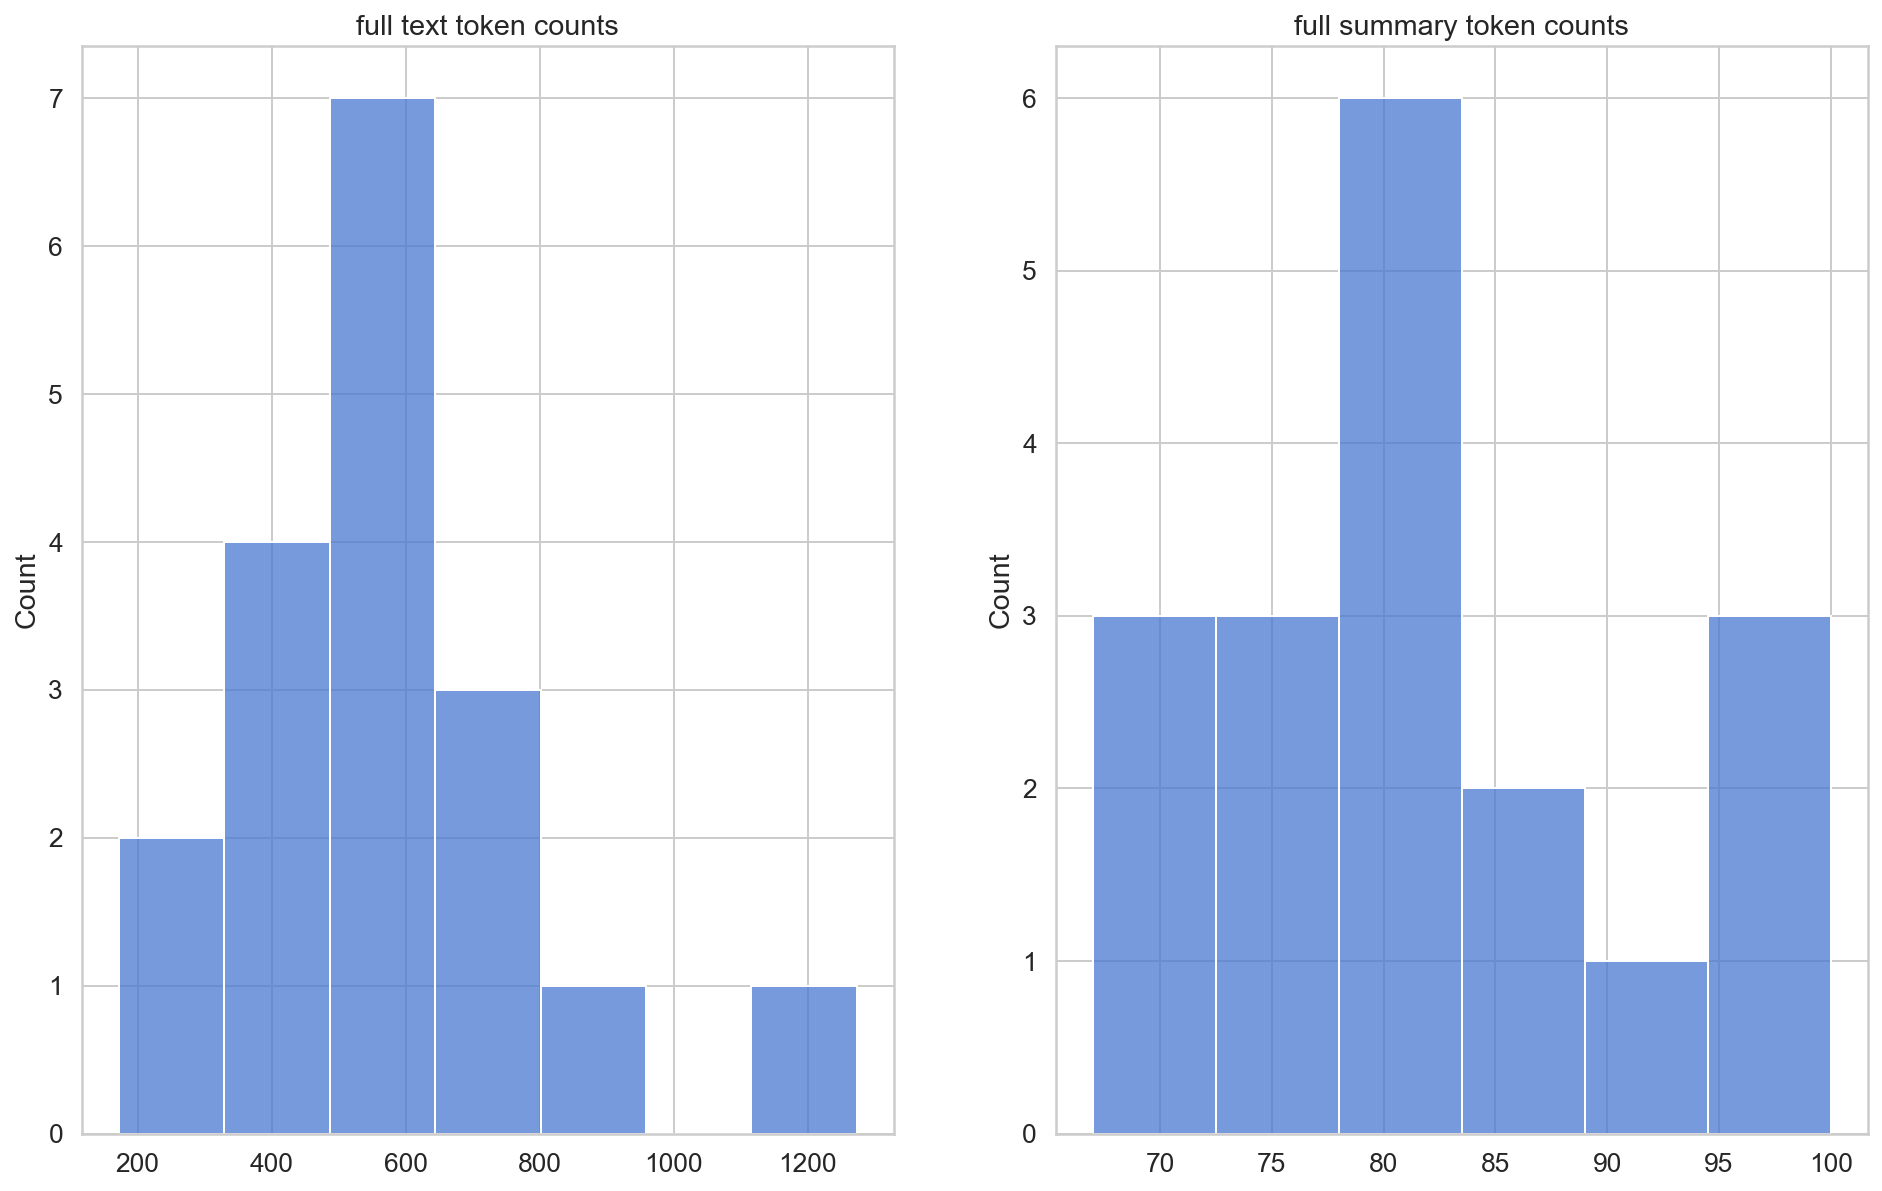

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title('full summary token counts')



In [25]:
N_EPOCH =3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer, batch_size=BATCH_SIZE)

In [26]:
# Model using pytorch lightning

In [27]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids, attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)


In [28]:
model = NewsSummaryModel()

In [29]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs_T5


Reusing TensorBoard on port 6006 (pid 72216), started 1:04:47 ago. (Use '!kill 72216' to kill it.)

In [30]:
cehckpoint_callback = ModelCheckpoint(
    dirpath='checkpoints_T5',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('./lightning_logs_T5', name='news_summary')

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=cehckpoint_callback,
    max_epochs=N_EPOCH,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [31]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [ ]:
def summarizer(text):
    text_encoding = tokenizer(text, max_lenghth=512, padding='max_length', truncation=True, return_attention_mask=True, add_special_tokens=True, return_tensors='pt')

    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask = text_encoding['attention_mask'],
        max_length=150,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )


    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    return ''.join(preds)

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row['text']
model_summary = summarize(text)

In [ ]:
text

In [ ]:
sample_row['summary']

In [ ]:
model_summary

In [1]:
!nvidia-smi

Thu Apr 15 12:54:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   62C    P8    14W /  N/A |    548MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------